In [46]:
import sys
import os



import numpy as np
from SynthTempNetwork import Individual, SynthTempNetwork
from TemporalNetwork import ContTempNetwork, StaticTempNetwork
from FlowStability import FlowIntegralClustering
import pickle

import matplotlib.pyplot as plt
import matplotlib

from scipy.sparse import (lil_matrix, dok_matrix, diags, eye, isspmatrix_csr, isspmatrix,
                          csr_matrix, coo_matrix, csc_matrix)
from scipy.sparse.linalg import eigsh                          

PID  803462  :  merged  212  events
PID  803462  :  merged  0  events
PID  803462  :  merged  212  events
PID  803462  :  merged  0  events


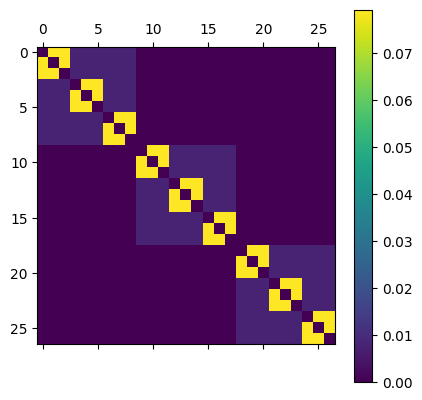

In [47]:
inter_tau = 10
activ_tau = 10
num_inter_per_activ = 1
t_start = 0
t_end = 250
n_groups = 27
n_per_group = 3
individuals = []

for g in range(n_groups):

    individuals.extend([Individual(i, inter_distro_scale=inter_tau,
                          activ_distro_scale=activ_tau, group=g) for i in \
            range(g*n_per_group,(g+1)*n_per_group)])


# level1 strength to level 2
r12 = 10
# level1 strength to level 3
r13 = r12*10
# level1 strength to background
# r14 = r13*10

# level 1 auto-strength with b4 = 0
b = 1/(1+2/r12+6/r13)
b1 = 0 #1/(1+2/r12+6/r13)
b2 =  b/r12 # b1/r12
b3 = b/r13 # b1/r13
b4 = 0


inter_module_probs = np.ones((3,3))*b3
sub_module_probs = np.array([[b1, b2, b2],
                             [b2, b1, b2],
                             [b2, b2, b1]])
    
B0 = np.concatenate((sub_module_probs,
                inter_module_probs,
                inter_module_probs),axis=1)
 
B1 = np.concatenate((inter_module_probs,
                sub_module_probs,
                inter_module_probs),axis=1)

B2 = np.concatenate((inter_module_probs,
                inter_module_probs,
                sub_module_probs),axis=1)

B = np.concatenate((B0,B1,B2),axis=0)

Cinter = np.ones_like(B)*b4

C = np.concatenate((np.concatenate((B,Cinter,Cinter),axis=1),
                    np.concatenate((Cinter,B,Cinter),axis=1),
                    np.concatenate((Cinter,Cinter,B),axis=1),
                    ),axis=0)

inter_group_probs = C

plt.matshow(C)
plt.colorbar()



sim = SynthTempNetwork(individuals=individuals, t_start=t_start, t_end=t_end,
                        next_event_method='block_probs',
                        inter_group_probs=inter_group_probs,
                        num_interactions_per_activation=num_inter_per_activ)

sim.run(save_all_states=True, save_dt_states=True, verbose=False)



net = ContTempNetwork(source_nodes=sim.indiv_sources,
                        target_nodes=sim.indiv_targets,
                        starting_times=sim.start_times,
                        ending_times=sim.end_times,
                        merge_overlapping_events=True)

net_heat = ContTempNetwork(source_nodes=sim.indiv_sources,
                        target_nodes=sim.indiv_targets,
                        starting_times=sim.start_times,
                        ending_times=sim.end_times,
                        merge_overlapping_events=True)
    

In [48]:
#plt.imshow(C, norm=matplotlib.colors.LogNorm(vmin=C.min()+0.000001, vmax=C.max()))
#plt.colorbar()

In [50]:
net.compute_laplacian_matrices(random_walk=True)
net_heat.compute_laplacian_matrices(random_walk=False)

In [51]:
# net.save('fig3_network250_3scales')
net_heat.save('fig3_network250_3scales23_heat')

In [6]:
lamdas=np.logspace(-4,2,20)
print(lamdas)

[1.00000000e-04 2.06913808e-04 4.28133240e-04 8.85866790e-04
 1.83298071e-03 3.79269019e-03 7.84759970e-03 1.62377674e-02
 3.35981829e-02 6.95192796e-02 1.43844989e-01 2.97635144e-01
 6.15848211e-01 1.27427499e+00 2.63665090e+00 5.45559478e+00
 1.12883789e+01 2.33572147e+01 4.83293024e+01 1.00000000e+02]


In [7]:
for i in lamdas:
    net.compute_inter_transition_matrices(lamda=i, dense_expm=False, use_sparse_stoch=False)
    net.compute_transition_matrices(lamda=i)
    net_heat.compute_inter_transition_matrices(lamda=i, dense_expm=False, use_sparse_stoch=False)
    net_heat.compute_transition_matrices(lamda=i)

In [ ]:
net = ContTempNetwork.load('fig3_network')

In [ ]:
list_forw_flows = []

for i in lamdas:
    list_forw_flows.append(FlowIntegralClustering(T_inter_list=net.inter_T[i],
                                  time_list=net.times,
                                  verbose=True))

In [ ]:
list_forw_flows[0].I_list[0]

In [ ]:
for i in range(len(lamdas)):
    list_forw_flows[i].find_louvain_clustering()

## Computing & Plotting Entropies

In [ ]:
for i in lamdas:
    net.compute_entropy(lamda=i, force_csr=True)
    # net.compute_vonNeumann_entropy(lamda=i, force_csr=True)
    net.compute_simple_vonNeumann_entropy(lamda=i, force_csr=True)
    #net.compute_entropy2(lamda=i, force_csr=True)

In [ ]:
for i in range(len(lamdas)):
    plt.subplot(1, 2, 1)
    plt.plot(net.times[0:-1], net.S[lamdas[i]], label='lamda = ' + str(round(lamdas[i], 3)) + '  #Communities= ' + str(len(list_forw_flows[i].partition[0].cluster_list)))

    plt.subplot(1, 2, 2)
    plt.plot(net.times[0:-1], net.S[lamdas[i]], label='lamda = ' + str(round(lamdas[i], 3)) + '  #Communities= ' + str(len(list_forw_flows[i].partition[0].cluster_list)), )
    plt.yscale('log')
plt.legend(fontsize='xx-small', loc='upper left', bbox_to_anchor=(1.05, 1))
plt.title('Entropy rate')
#plt.savefig('./fig_entropy_rate', format='eps')

plt.show()

In [ ]:
for i in range(len(lamdas)):
    plt.subplot(1, 2, 1)
    plt.plot(net.times[0:-1], net.simple_vNS[lamdas[i]], label='lamda = ' + str(round(lamdas[i], 3)) + '  #Communities= ' + str(len(list_forw_flows[i].partition[0].cluster_list)))

    plt.subplot(1, 2, 2)
    plt.plot(net.times[0:-1], net.simple_vNS[lamdas[i]], label='lamda = ' + str(round(lamdas[i], 3)) + '  #Communities= ' + str(len(list_forw_flows[i].partition[0].cluster_list)), )
    plt.yscale('log')
plt.legend(fontsize='xx-small', loc='upper left', bbox_to_anchor=(1.05, 1))
plt.title('Simplified Von Neumann Entropy')
#plt.savefig('./fig_simple_vNEntropy', format='eps')

In [ ]:
for i in range(len(lamdas)):
    plt.subplot(1, 2, 1)
    plt.plot(net.S2[lamdas[i]], label='lamda = ' + str(round(lamdas[i], 3)) + '  #Communities= ' + str(len(list_forw_flows[i].partition[0].cluster_list)))

    plt.subplot(1, 2, 2)
    plt.plot(net.S2[lamdas[i]], label='lamda = ' + str(round(lamdas[i], 3)) + '  #Communities= ' + str(len(list_forw_flows[i].partition[0].cluster_list)), )
    plt.yscale('log')
plt.legend(fontsize='xx-small', loc='lower right')
plt.title('Complicated Entropy')
#plt.savefig('./fig_complicated_entropy', format='eps')

In [ ]:
for i in range(len(lamdas)):
    plt.subplot(1, 2, 1)
    plt.plot(net.times[0:-1], [net.T[lamdas[i]][j].trace() for j in range(len(net.T[lamdas[i]]))], label='lamda = ' + str(round(lamdas[i], 3)) + '  #Communities= ' + str(len(list_forw_flows[i].partition[0].cluster_list)))

    plt.subplot(1, 2, 2)
    plt.plot(net.times[0:-1], [net.T[lamdas[i]][j].trace() for j in range(len(net.T[lamdas[i]]))], label='lamda = ' + str(round(lamdas[i], 3)) + '  #Communities= ' + str(len(list_forw_flows[i].partition[0].cluster_list)), )
    plt.yscale('log')
plt.legend(fontsize='xx-small', loc='upper left')
plt.title('Trace of T')

In [ ]:
plt.matshow((net.T[lamdas[9]][100] / net.T[lamdas[9]][100].trace()).todense())
plt.colorbar()

In [ ]:
fig, axs = plt.subplots(nrows=len(lamdas), ncols=9, figsize=(20,40))

for i in range(len(lamdas)):
    for j in range(9):
        rho = net.T[lamdas[i]][220+20*j] / net.T[lamdas[i]][220+20*j].trace()
        axs[i][j].matshow(rho.todense())

fig.tight_layout()

In [ ]:
fig, axs = plt.subplots(nrows=len(lamdas), ncols=9, figsize=(20,40))

for i in range(len(lamdas)):
    for j in range(9):
        rho = net.T[lamdas[i]][220+20*j] / net.T[lamdas[i]][220+20*j].trace()
        np_rhologrho = rho.data * np.log(rho.data)
        np_rhologrho[np.isnan(np_rhologrho)] = 0
        rhologrho = csr_matrix((np_rhologrho, rho.indices, rho.indptr), shape=rho.shape)
        del np_rhologrho
        axs[i][j].matshow(rhologrho.todense())
fig.tight_layout()

In [ ]:
fig, axs = plt.subplots(nrows=len(lamdas), ncols=8, figsize=(20,40))

for i in range(len(lamdas)):
    for j in range(8):
        rho = net.T[lamdas[i]][296+j] / net.T[lamdas[i]][298+j].trace()
        np_rhologrho = rho.data * np.log(rho.data)
        np_rhologrho[np.isnan(np_rhologrho)] = 0
        rhologrho = csr_matrix((np_rhologrho, rho.indices, rho.indptr), shape=rho.shape)
        del np_rhologrho
        axs[i][j].plt(rhologrho.todense())
fig.tight_layout()

In [ ]:
sum_ex = 0
for i in range(laplacianex.shape[0]):
    col_i = laplacianex.getcol(i)
    row_i = laplacianex.getrow(i)
    divide = np.divide(col_i,row_i)
    divide[np.isnan(divide)] = 0
    sum_ex += np.sum(divide)

# Static Network, Random Walk Lalacian

In [ ]:
# static_net_adj = net.compute_static_adjacency_matrix()
# static_net = StaticTempNetwork(times = net.times, adjacency = static_net_adj)
# static_net.compute_laplacian_matrices(random_walk = True)
# for i in lamdas:
#     static_net.compute_inter_transition_matrices(lamda=i, dense_expm=False, use_sparse_stoch=False)
#     static_net.compute_transition_matrices(lamda=i)

In [ ]:
#static_net.save('fig3_network_static')

In [ ]:
static_net = StaticTempNetwork.load('fig3_network_static')

### Computing & Plotting Entropies

In [ ]:
for i in lamdas:
    static_net.compute_entropy(lamda=i, force_csr=True)
    static_net.compute_spectral_vonNeumann_entropy(lamda=i, force_csr=True)
    # static_net.compute_vonNeumann_entropy(lamda=i, force_csr=True)
    #static_net.compute_simple_vonNeumann_entropy(lamda=i, force_csr=True)
    #static_net.compute_entropy2(lamda=i, force_csr=True)

In [ ]:
for i in range(len(lamdas)):
    plt.subplot(1, 2, 1)
    plt.plot(net.times[0:], static_net.S[lamdas[i]], label='lamda = ' + str(round(lamdas[i], 3)) + '  #Communities= ' + str(len(list_forw_flows[i].partition[0].cluster_list)))

    plt.subplot(1, 2, 2)
    plt.plot(net.times[0:], static_net.S[lamdas[i]], label='lamda = ' + str(round(lamdas[i], 3)) + '  #Communities= ' + str(len(list_forw_flows[i].partition[0].cluster_list)), )
    plt.yscale('log')
plt.legend(fontsize='xx-small', loc='lower right')
plt.title('Entropy rate')
#plt.savefig('./fig_entropy_rate', format='eps')

plt.show()

In [ ]:
for i in range(len(lamdas)):
    plt.subplot(1, 2, 1)
    plt.plot(net.times[0:], static_net.spectral_vNS[lamdas[i]], label='lamda = ' + str(round(lamdas[i], 3)) + '  #Communities= ' + str(len(list_forw_flows[i].partition[0].cluster_list)))

    plt.subplot(1, 2, 2)
    plt.plot(net.times[0:], static_net.spectral_vNS[lamdas[i]], label='lamda = ' + str(round(lamdas[i], 3)) + '  #Communities= ' + str(len(list_forw_flows[i].partition[0].cluster_list)), )
    plt.yscale('log')
plt.legend(fontsize='xx-small', loc='lower right')
plt.title('Spectral vNS')
#plt.savefig('./fig_entropy_rate', format='eps')

plt.show()

In [ ]:
for i in range(len(lamdas)):
    plt.subplot(1, 2, 1)
    plt.plot(net.times[0:], static_net.simple_vNS[lamdas[i]], label='lamda = ' + str(round(lamdas[i], 3)) + '  #Communities= ' + str(len(list_forw_flows[i].partition[0].cluster_list)))

    plt.subplot(1, 2, 2)
    plt.plot(net.times[0:], static_net.simple_vNS[lamdas[i]], label='lamda = ' + str(round(lamdas[i], 3)) + '  #Communities= ' + str(len(list_forw_flows[i].partition[0].cluster_list)), )
    plt.yscale('log')
plt.legend(fontsize='xx-small', loc='lower right')
plt.title('Simplified Von Neumann Entropy')
#plt.savefig('./fig_simple_vNEntropy', format='eps')

In [ ]:
for i in range(len(lamdas)):
    plt.subplot(1, 2, 1)
    plt.plot(net.times[0:], [static_net.T[lamdas[i]][j].trace() for j in range(len(static_net.T[lamdas[i]]))], label='lamda = ' + str(round(lamdas[i], 3)) + '  #Communities= ' + str(len(list_forw_flows[i].partition[0].cluster_list)))

    plt.subplot(1, 2, 2)
    plt.plot(net.times[0:], [static_net.T[lamdas[i]][j].trace() for j in range(len(static_net.T[lamdas[i]]))], label='lamda = ' + str(round(lamdas[i], 3)) + '  #Communities= ' + str(len(list_forw_flows[i].partition[0].cluster_list)), )
    plt.yscale('log')
plt.legend(fontsize='xx-small', loc='lower right')
plt.title('Trace of T')

# Static Network, Combinatorial Laplacian

In [ ]:
# static_net_adj = net.compute_static_adjacency_matrix().todense()
# #entries are sum of durations of events, need to set to 1
# static_net_adj[static_net_adj != 0] = 1
# static_net_adj = csr_matrix(static_net_adj)

# static_net_heat = StaticTempNetwork(times = net.times, adjacency = static_net_adj)
# static_net_heat.compute_laplacian_matrices(random_walk = False)
# for i in lamdas:
#     static_net_heat.compute_inter_transition_matrices(lamda=i, dense_expm=False, use_sparse_stoch=False)
#     static_net_heat.compute_transition_matrices(lamda=i)

In [ ]:
# static_net_heat.save('fig3_network_static_heat')

In [ ]:
static_net_heat = StaticTempNetwork.load('fig3_network_static_heat')

In [ ]:
for i in lamdas:
    static_net_heat.compute_entropy(lamda=i, force_csr=True)

In [ ]:
for i in range(len(lamdas)):
    plt.subplot(1, 2, 1)
    plt.plot(static_net_heat.S[lamdas[i]], label='lamda = ' + str(round(lamdas[i], 3)) + '  #Communities= ' + str(len(list_forw_flows[i].partition[0].cluster_list)))

    plt.subplot(1, 2, 2)
    plt.plot(static_net_heat.S[lamdas[i]], label='lamda = ' + str(round(lamdas[i], 3)) + '  #Communities= ' + str(len(list_forw_flows[i].partition[0].cluster_list)), )
    plt.yscale('log')
plt.legend(fontsize='xx-small', loc='lower right')
plt.title('Entropy rate')
#plt.savefig('./fig_entropy_rate', format='eps')

plt.show()

In [ ]:
for i in lamdas:
    static_net_heat.compute_spectral_vonNeumann_entropy(lamda=i, force_csr=True)

In [ ]:
for i in range(len(lamdas)):
    plt.subplot(1, 2, 1)
    plt.plot(static_net_heat.spectral_vNS[lamdas[i]], label='lamda = ' + str(round(lamdas[i], 3)) + '  #Communities= ' + str(len(list_forw_flows[i].partition[0].cluster_list)))

    plt.subplot(1, 2, 2)
    plt.plot(static_net_heat.spectral_vNS[lamdas[i]], label='lamda = ' + str(round(lamdas[i], 3)) + '  #Communities= ' + str(len(list_forw_flows[i].partition[0].cluster_list)), )
    plt.yscale('log')
plt.legend(fontsize='xx-small', loc='lower right')
plt.title('Spectral Von Neumann Entropy')
#plt.savefig('./fig_simple_vNEntropy', format='eps')

In [ ]:
for i in lamdas:
    static_net_heat.compute_vonNeumann_entropy(lamda=i, force_csr=True)

In [ ]:
for i in range(len(lamdas)):
    plt.subplot(1, 2, 1)
    plt.plot(static_net_heat.vNS[lamdas[i]], label='lamda = ' + str(round(lamdas[i], 3)) + '  #Communities= ' + str(len(list_forw_flows[i].partition[0].cluster_list)))

    plt.subplot(1, 2, 2)
    plt.plot(static_net_heat.vNS[lamdas[i]], label='lamda = ' + str(round(lamdas[i], 3)) + '  #Communities= ' + str(len(list_forw_flows[i].partition[0].cluster_list)), )
    plt.yscale('log')
plt.legend(fontsize='xx-small', loc='lower right')
plt.title('Von Neumann Entropy')
#plt.savefig('./fig_simple_vNEntropy', format='eps')

In [ ]:
for i in lamdas:
    static_net_heat.compute_simple_vonNeumann_entropy(lamda=i, force_csr=True)

In [ ]:
for i in range(len(lamdas)):
    plt.subplot(1, 2, 1)
    plt.plot(static_net_heat.simple_vNS[lamdas[i]], label='lamda = ' + str(round(lamdas[i], 3)) + '  #Communities= ' + str(len(list_forw_flows[i].partition[0].cluster_list)))

    plt.subplot(1, 2, 2)
    plt.plot(static_net_heat.simple_vNS[lamdas[i]], label='lamda = ' + str(round(lamdas[i], 3)) + '  #Communities= ' + str(len(list_forw_flows[i].partition[0].cluster_list)), )
    plt.yscale('log')
plt.legend(fontsize='xx-small', loc='lower right')
plt.title('Simplified Von Neumann Entropy')
#plt.savefig('./fig_simple_vNEntropy', format='eps')

In [ ]:
for i in lamdas:
    static_net_heat.compute_new_vonNeumann_entropy(lamda=i, force_csr=True)

In [ ]:
for i in range(len(lamdas)):
    entropy_list = static_net_heat.new_vNS
    color = plt.cm.viridis(i / len(entropy_list))
    
    plt.subplot(1, 2, 1)
    plt.plot(entropy_list[lamdas[i]], label='lamda = ' + str(round(lamdas[i], 3)) + '  #Communities= ' + str(len(list_forw_flows[i].partition[0].cluster_list)), color=color)

    plt.subplot(1, 2, 2)
    plt.plot(entropy_list[lamdas[i]], label='lamda = ' + str(round(lamdas[i], 3)) + '  #Communities= ' + str(len(list_forw_flows[i].partition[0].cluster_list)) , color=color)
    plt.yscale('log')
plt.legend(fontsize='xx-small', loc='lower right')
plt.title('New von Neumann Entropy (heat version)')
#plt.savefig('./fig_entropy_rate', format='eps')

plt.show()

## Trace

In [ ]:
for i in range(len(lamdas)):
    plt.subplot(1, 2, 1)
    plt.plot([static_net_heat.T[lamdas[i]][j].trace() for j in range(len(static_net.T[lamdas[i]]))], label='lamda = ' + str(round(lamdas[i], 3)) + '  #Communities= ' + str(len(list_forw_flows[i].partition[0].cluster_list)))

    plt.subplot(1, 2, 2)
    plt.plot([static_net_heat.T[lamdas[i]][j].trace() for j in range(len(static_net.T[lamdas[i]]))], label='lamda = ' + str(round(lamdas[i], 3)) + '  #Communities= ' + str(len(list_forw_flows[i].partition[0].cluster_list)), )
    plt.yscale('log')
plt.legend(fontsize='xx-small', loc='lower right')
plt.title('Trace of T')

# Derivatives

In [ ]:
v1 = net.S[lamdas[0]]
v2 = net.times[:-1]
print(len(v1))
print(len(net.times[:-1]))

In [ ]:
def derivative(v1, v2):
    assert len(v1) == len(v2), "Error: in order to compute the numerical derivative, the two varibales need to have the same lenght."
    derivative = []
    for i, vi in enumerate(v1[1:]):
        m1 =(vi - v1[i-1])/(v2[i]-v2[i-1])
        m2 =(v1[i+1] - vi)/(v2[i+1]-v2[i])
        derivative.append((m1+m2)/2)
    return derivative

In [ ]:
for i in range(len(lamdas)):
    v1 = net.S[lamdas[i]]
    v2 = net.times[:-1]
    ds_dt = derivative(v1, v2)

    plt.plot(net.times[1:-1], ds_dt, label='lamda = ' + str(round(lamdas[i], 3)) + '  #Communities= ' + str(len(list_forw_flows[i].partition[0].cluster_list)))

plt.legend(fontsize='xx-small', loc='upper left', bbox_to_anchor=(1.05, 1))
plt.title('d(Entropy rate) / dt')
#plt.savefig('./fig_entropy_rate', format='eps')

plt.show()

In [ ]:
between_lamdas=np.linspace(-4,2,20)

In [ ]:
S0= []
for i, lamda in enumerate(lamdas):
    S0.append(net.S[lamda][0])
print(S0)

In [ ]:
sample_times = np.arange(0, len(net.times), 64)
print(sample_times)

### Derivative Entropy Rate

In [ ]:
for i, t in enumerate(sample_times):

    St = []
    for j, lamda in enumerate(lamdas):
        St.append(net.S[lamda][t])
    
    v1 = St
    v2 = between_lamdas
    ds_dt = derivative(v1, v2)

    plt.subplot(1, 2, 1)
    plt.plot(lamdas[1:], ds_dt, label='t = ' + str(round(t, 3)))

    plt.subplot(1, 2, 2)
    plt.plot(lamdas[1:], ds_dt, label='t = ' + str(round(t, 3)))
    plt.xscale('log')
    
   

plt.legend(fontsize='xx-small', loc='upper left', bbox_to_anchor=(1.05, 1))
plt.title('d(Entropy rate) / dlamda')
#plt.savefig('./fig_entropy_rate', format='eps')

plt.show()

### Derivative Simplified Von Neumann

In [ ]:
for i, t in enumerate(sample_times):

    St = []
    for j, lamda in enumerate(lamdas):
        St.append(net.simple_vNS[lamda][t])
    
    v1 = St
    v2 = between_lamdas
    ds_dt = derivative(v1, v2)

    plt.subplot(1, 2, 1)
    plt.plot(lamdas[1:], ds_dt, label='t = ' + str(round(t, 3)))

    plt.subplot(1, 2, 2)
    plt.plot(lamdas[1:], ds_dt, label='t = ' + str(round(t, 3)))
    plt.xscale('log')

plt.legend(fontsize='xx-small', loc='upper left', bbox_to_anchor=(1.05, 1))
plt.title('d(Simple vNS) / dlamda')
#plt.savefig('./fig_entropy_rate', format='eps')

plt.show()

# Derivatives Static Network

In [ ]:
static_net.times

In [ ]:
len(static_net.S[lamdas[0]])

In [ ]:
for i in range(len(lamdas)):
    v1 = static_net.S[lamdas[i]]
    v2 = static_net.times[:]
    ds_dt = derivative(v1, v2)

    plt.plot(static_net.times[1:], ds_dt, label='lamda = ' + str(round(lamdas[i], 3)) + '  #Communities= ' + str(len(list_forw_flows[i].partition[0].cluster_list)))

plt.legend(fontsize='xx-small', loc='upper left', bbox_to_anchor=(1.05, 1))
plt.title('Static Network: d(Entropy rate) / dt')
#plt.savefig('./fig_entropy_rate', format='eps')

plt.show()

In [ ]:
between_lamdas=np.linspace(-4,2,20)

In [ ]:
sample_times = np.arange(0, len(static_net_heat.times), 64)
print(sample_times)

### Derivative Entropy Rate

In [ ]:
for i, t in enumerate(sample_times):

    St = []
    for j, lamda in enumerate(lamdas):
        St.append(static_net.S[lamda][t])
    
    v1 = St
    v2 = between_lamdas
    ds_dt = derivative(v1, v2)

    plt.subplot(1, 2, 1)
    plt.plot(lamdas[1:], ds_dt, label='t = ' + str(round(t, 3)))

    plt.subplot(1, 2, 2)
    plt.plot(lamdas[1:], ds_dt, label='t = ' + str(round(t, 3)))
    plt.xscale('log')
    
   

plt.legend(fontsize='xx-small', loc='upper left', bbox_to_anchor=(1.05, 1))
plt.title('d(Entropy rate) / dlamda')
#plt.savefig('./fig_entropy_rate', format='eps')

plt.show()

### Derivative Spectral Von Neumann

In [ ]:
for i, t in enumerate(sample_times):

    St = []
    for j, lamda in enumerate(lamdas):
        St.append(static_net_heat.spectral_vNS[lamda][t])
    
    v1 = St
    v2 = between_lamdas
    ds_dt = derivative(v1, v2)

    plt.subplot(1, 2, 1)
    plt.plot(lamdas[1:], ds_dt, label='t = ' + str(round(t, 3)))

    plt.subplot(1, 2, 2)
    plt.plot(lamdas[1:], ds_dt, label='t = ' + str(round(t, 3)))
    plt.xscale('log')

plt.legend(fontsize='xx-small', loc='upper left', bbox_to_anchor=(1.05, 1))
plt.title('Static Network: d(Spectral vNS) / dlamda')
#plt.savefig('./fig_entropy_rate', format='eps')

plt.show()

In [ ]:
plt.matshow(static_net.adjacency.todense())
plt.colorbar()

# Static weighted network

In [ ]:
static_net_weighted_adj = net.compute_static_adjacency_matrix().todense()
static_net_weighted_adj = csr_matrix(static_net_weighted_adj)

static_net_weighted_heat = StaticTempNetwork(times = net.times, adjacency = static_net_weighted_adj)
static_net_weighted_heat.compute_laplacian_matrices(random_walk = False)
for i in lamdas:
    static_net_weighted_heat.compute_inter_transition_matrices(lamda=i, dense_expm=False, use_sparse_stoch=False)
    static_net_weighted_heat.compute_transition_matrices(lamda=i)

In [ ]:
static_net_weighted_heat.save('fig3_network_static_weighted_heat')